# 3.0 Pre-processing and Training

Contents

3.1 [Introduction](#3.1)

  * [3.1.1 Problem Recap](#3.1.1)
  * [3.1.2 Notebook Goals](#3.1.2)
 
3.2 [Load the data](#3.2)

  * [3.2.1 Imports](#3.2.1)
  * [3.2.2 Load the data](#3.2.2)

3.3 [Examine Class Split](#3.3)

3.4 [Pre-processing](#3.4)

  * [3.4.1 Set Random Seed for Reproducability](#3.4.1)
  * [3.4.2 Train/test Split](#3.4.2)
  * [3.4.3 Examine Class Split for Train/Test Data](#3.4.3)
  

3.5 [Vectorizing the Text](#3.5)

  * [3.5.1 Count Vectorization](#3.5.1)
  * [3.5.2 Term-Frequency Inverse-Document Frequency](#3.5.2)

3.6 [Building a Simple Model](#3.6)
  * 3.6.1 [Logistic Regression](#3.6.1)
<br/><br/>
    * [3.6.1.1 Training the Model](#3.6.1.1)
    * [3.6.1.2 Fitting the Model](#3.6.1.2)
    * [3.6.1.3 Evaluating the Model](#3.6.1.3)
<br/><br/>
  * 3.6.2 [Naive Bayes](#3.6.2)
<br/> <br/> 
    * [3.6.2.1 Training the Model](#3.6.1.1)
    * [3.6.2.2 Fitting the Model](#3.6.2.2)
    * [3.6.2.3 Evaluating the Model](#3.6.2.3)
<br/> <br/>
  * 3.6.3 [SVM Classifier](#3.6.3)
<br/>  <br/>
    * [3.6.3.1 Training the Model](#3.6.3.1)
    * [3.6.3.2 Fitting the Model](#3.6.3.2)
    * [3.6.3.3 Evaluating the Model](#3.6.3.3)



## 3.1 Introduction <a name="3.1"></a>

### 3.1.1 Problem Recap <a name="3.1.1"><a/>

Using customer text data about amazon products, we will build, evaluate and compare models to estimate the probability that a given text review can be classified as “positive” or “negative”.

Our goal is to build a text classifier using Amazon product review data which can be used to analyze customer sentiment which does not have accompanying numeric data.

### 3.1.2 Notebook Goals <a name="3.1.2"></a>

1. Examine the split between the class we're trying to predict.

2. Split the data into train and test sets.

3. Convert our text review data into numeric features. (CountVectorization, TFIDF, and word2vec are options)

4. Build a few simple, initial predictive models.

5. Logistic Regression predicts probabilities. With "positive" (0) and "negative" (1) review, we can do a binary classification.

6. Measure the performance of the model with a Classification Report, Confusion Matrix and ROC + AUC.

## 3.2 Load the data <a name="3.2"><a/>

### 3.2.1 Imports <a name="3.2.1"><a/>

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from random import seed
from sklearn.linear_model import LogisticRegression

### 3.2.2 Load the data <a name="3.2.2"><a/>

In [4]:
data = pq.read_table("../data/edited/fashion.parquet")
fashion = data.to_pandas()

In [5]:
fashion.head()

,review,neg_sentiment,stars,review_length
0,exactly needed,0,5,4
1,agree review opening small bent hook expensiv...,1,2,49
2,love going order pack work including losing ea...,0,4,50
3,tiny opening,1,2,4
4,okay,1,3,1


In [6]:
fashion.describe()

,neg_sentiment,stars,review_length
count,873352.000000,873352.000000,873352.000000
mean,0.304939,3.904786,29.131591
std,0.460382,1.419361,39.372047
min,0.000000,1.000000,1.000000
25%,0.000000,3.000000,7.000000
50%,0.000000,5.000000,17.000000
75%,1.000000,5.000000,36.000000
max,1.000000,5.000000,2196.000000


In [7]:
fashion.shape

(873352, 4)

## 3.3 Examine Class Split <a name="3.3"><a/>

In [31]:
def plot_sentiment_split(df_col:pd.Series):

    df_col.value_counts().plot(kind="pie")
    plt.legend(labels=("Positive Reviews","Negative Reviews"))
    plt.title("Review Sentiment Split")
    plt.show()

    positive, negative = df_col.value_counts(normalize=True).values

    pos_perc = round(positive * 100, 2)
    neg_perc = round(negative * 100, 2)
    print(f"Positive reviews: {pos_perc}%\n", f"Negative reviews: {neg_perc}%")

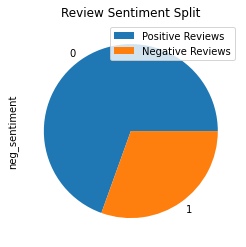

Positive reviews: 69.51%
 Negative reviews: 30.49%


In [34]:
plot_sentiment_split(fashion["neg_sentiment"])

We have more than double the positive reviews vs. negative reviews. The class we are trying to predict is negative reviews which are coded as "1".

## 3.4 Pre-Processing <a name="3.4"><a/>

### 3.4.1 Set Random Seed for Reproducability <a name="3.4.1"><a/>

In [9]:
seed(42)

### 3.4.2 Train/Test Split <a name="3.4.2"><a/>

In [87]:
X_train, X_test, y_train, y_test = train_test_split(fashion["review"], fashion["neg_sentiment"], test_size = .1)

### 3.4.3 Examine Class Split for Train/Test Data <a name="3.4.3"><a/>

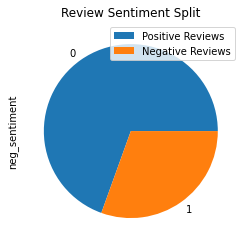

Positive reviews: 69.49%
 Negative reviews: 30.51%


In [37]:
plot_sentiment_split(y_train)

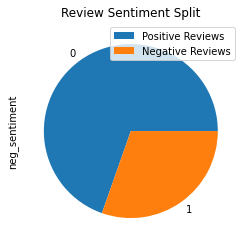

Positive reviews: 69.61%
 Negative reviews: 30.39%


In [38]:
plot_sentiment_split(y_test)

The train-test split is very representative of the split of the entire dataset (roughly .1 percent difference).

## 3.5 Vectorizing the Text <a name="3.5"><a/>

In [88]:
vectorizer1 = CountVectorizer()

In [89]:
vectorizer1.fit(X_train)

CountVectorizer()

In [90]:
X_train_vec = vectorizer1.transform(X_train)
X_test_vec = vectorizer1.transform(X_test)

## 3.5 Initial Modeling <a name="3.4"></a>

In [95]:
scaler = StandardScaler(with_mean=False)

In [96]:
X_train = scaler.fit_transform(X_train_vec)

In [97]:
lr = LogisticRegression(n_jobs=-1, max_iter=500)

In [98]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=500, n_jobs=-1)

In [99]:
preds = lr.predict(X_train)

In [100]:
(preds==y_train).value_counts()

True     709892
False     76124
Name: neg_sentiment, dtype: int64

In [103]:
X_test = scaler.transform(X_test_vec)

In [105]:
y_preds = lr.predict(X_test)

In [106]:
(y_preds == y_test).value_counts()

True     76451
False    10885
Name: neg_sentiment, dtype: int64